<a href="https://colab.research.google.com/github/standroidbeta/DS-Unit-1-Sprint-1-Dealing-With-Data/blob/master/module4-databackedassertions/LS_DS_114_Making_Data_backed_Assertions.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Lambda School Data Science - Making Data-backed Assertions

This is, for many, the main point of data science - to create and support reasoned arguments based on evidence. It's not a topic to master in a day, but it is worth some focused time thinking about and structuring your approach to it.

## Lecture - generating a confounding variable

The prewatch material told a story about a hypothetical health condition where both the drug usage and overall health outcome were related to gender - thus making gender a confounding variable, obfuscating the possible relationship between the drug and the outcome.

Let's use Python to generate data that actually behaves in this fashion!

In [0]:
import random
import random
random.seed(42) # Random seed for reproducibility
# dir(random)  # Reminding ourselves what we can do here

In [2]:
# Let's think of another scenario:
# We work for a company that sells accessories for mobile phones.
# They have an ecommerce site, and we are supposed to analyze logs
# to determine what sort of usage is related to purchases, and thus guide
# website development to encourage higher conversion.

# The hypothesis - users who spend longer on the site tend
# to spend more. Seems reasonable, no?

# But there's a confounding variable! If they're on a phone, they:
# a) Spend less time on the site, but
# b) Are more likely to be interested in the actual products!

# Let's use namedtuple to represent our data

from collections import namedtuple
# purchased and mobile are bools, time_on_site in seconds
User = namedtuple('User', ['purchased','time_on_site', 'mobile'])

example_user = User(False, 12, False)
print(example_user)

User(purchased=False, time_on_site=12, mobile=False)


In [3]:
# And now let's generate 1000 example users
# 750 mobile, 250 not (i.e. desktop)
# A desktop user has a base conversion likelihood of 10%
# And it goes up by 1% for each 15 seconds they spend on the site
# And they spend anywhere from 10 seconds to 10 minutes on the site (uniform)
# Mobile users spend on average half as much time on the site as desktop
# But have three times as much base likelihood of buying something

users = []

for _ in range(250):
  # Desktop users
  time_on_site = random.uniform(10, 600)
  purchased = random.random() < 0.1 + (time_on_site / 1500)
  users.append(User(purchased, time_on_site, False))
  
for _ in range(750):
  # Mobile users
  time_on_site = random.uniform(5, 300)
  purchased = random.random() < 0.3 + (time_on_site / 1500)
  users.append(User(purchased, time_on_site, True))
  
random.shuffle(users)
print(users[:10])

[User(purchased=False, time_on_site=150.42273427770718, mobile=False), User(purchased=True, time_on_site=284.06235530493245, mobile=True), User(purchased=True, time_on_site=140.37976895454653, mobile=True), User(purchased=True, time_on_site=49.206452507812216, mobile=True), User(purchased=False, time_on_site=167.81563803588924, mobile=True), User(purchased=False, time_on_site=20.484876517641524, mobile=True), User(purchased=False, time_on_site=167.3540069049869, mobile=True), User(purchased=False, time_on_site=447.75054592529114, mobile=False), User(purchased=True, time_on_site=57.93525538719398, mobile=True), User(purchased=True, time_on_site=292.6494305470663, mobile=True)]


In [4]:
# Let's put this in a dataframe so we can look at it more easily
import pandas as pd
user_data = pd.DataFrame(users)
user_data.head()

,purchased,time_on_site,mobile
0,False,150.422734,False
1,True,284.062355,True
2,True,140.379769,True
3,True,49.206453,True
4,False,167.815638,True


In [5]:
# Let's use crosstabulation to try to see what's going on
print(pd.crosstab(user_data['purchased'], user_data['time_on_site']).shape)
pd.crosstab(user_data['purchased'], user_data['time_on_site'])

(2, 1000)


time_on_site,5.789338167851291,5.836487686604824,7.267690340465448,7.280322437947023,7.733814701629437,7.772242279186957,7.994578759409748,8.373541587279558,9.106003254765849,9.38379653305911,...,582.5363605031145,582.9362427920347,588.8783154469735,590.65747470592,593.8187768755912,597.1381204299279,597.7116143416571,598.547187832115,599.088120104121,599.5766563635087
purchased,,,,,,,,,,,,,,,,,,,,,
False,1,1,0,1,1,1,1,1,1,1,...,0,1,1,0,1,1,1,1,1,1
True,0,0,1,0,0,0,0,0,0,0,...,1,0,0,1,0,0,0,0,0,0


In [6]:
# OK, that's not quite what we want
# Time is continuous! We need to put it in discrete buckets
# Pandas calls these bins, and pandas.cut helps make them

time_bins = pd.cut(user_data['time_on_site'], 5)  # 5 equal-sized bins
pd.crosstab(user_data['purchased'], time_bins)

time_on_site,"(5.196, 124.547]","(124.547, 243.304]","(243.304, 362.062]","(362.062, 480.819]","(480.819, 599.577]"
purchased,,,,,
False,227,238,111,23,37
True,106,133,84,20,21


In [7]:
# We can make this a bit clearer by normalizing (getting %)
pd.crosstab(user_data['purchased'], time_bins, normalize='columns')

time_on_site,"(5.196, 124.547]","(124.547, 243.304]","(243.304, 362.062]","(362.062, 480.819]","(480.819, 599.577]"
purchased,,,,,
False,0.681682,0.641509,0.569231,0.534884,0.637931
True,0.318318,0.358491,0.430769,0.465116,0.362069


In [8]:
# That seems counter to our hypothesis
# More time on the site can actually have fewer purchases

# But we know why, since we generated the data!
# Let's look at mobile and purchased
pd.crosstab(user_data['purchased'], user_data['mobile'], normalize='columns')

mobile,False,True
purchased,,
False,0.704,0.613333
True,0.296,0.386667


In [9]:
# Yep, mobile users are more likely to buy things
# But we're still not seeing the *whole* story until we look at all 3 at once
pd.crosstab(user_data['mobile'], [user_data['purchased'], time_bins], 
            rownames=['device'], 
            colnames=["purchased", "time on site"], 
            normalize='index')
# Live/stretch goal - how can we do that?

purchased               False                                        \
time on site (5.196, 124.547] (124.547, 243.304] (243.304, 362.062]   
device                                                                
False                0.148000              0.172              0.144   
True                 0.253333              0.260              0.100   

purchased                                                     True   \
time on site (362.062, 480.819] (480.819, 599.577] (5.196, 124.547]   
device                                                                
False                     0.092              0.148            0.016   
True                      0.000              0.000            0.136   

purchased                                                              \
time on site (124.547, 243.304] (243.304, 362.062] (362.062, 480.819]   
device                                                                  
False                  0.044000              0.072               0.08   
True                   0.162667              0.088               0.00   

purchased                        
time on site (480.819, 599.577]  
device                           
False                     0.084  
True                      0.000

In [10]:
help(user_data.plot)

Help on FramePlotMethods in module pandas.plotting._core object:

class FramePlotMethods(BasePlotMethods)
 |  DataFrame plotting accessor and method
 |  
 |  Examples
 |  --------
 |  >>> df.plot.line()
 |  >>> df.plot.scatter('x', 'y')
 |  >>> df.plot.hexbin()
 |  
 |  These plotting methods can also be accessed by calling the accessor as a
 |  method with the ``kind`` argument:
 |  ``df.plot(kind='line')`` is equivalent to ``df.plot.line()``
 |  
 |  Method resolution order:
 |      FramePlotMethods
 |      BasePlotMethods
 |      pandas.core.base.PandasObject
 |      pandas.core.base.StringMixin
 |      pandas.core.accessor.DirNamesMixin
 |      builtins.object
 |  
 |  Methods defined here:
 |  
 |  __call__(self, x=None, y=None, kind='line', ax=None, subplots=False, sharex=None, sharey=False, layout=None, figsize=None, use_index=True, title=None, grid=None, legend=True, style=None, logx=False, logy=False, loglog=False, xticks=None, yticks=None, xlim=None, ylim=None, rot=None, font

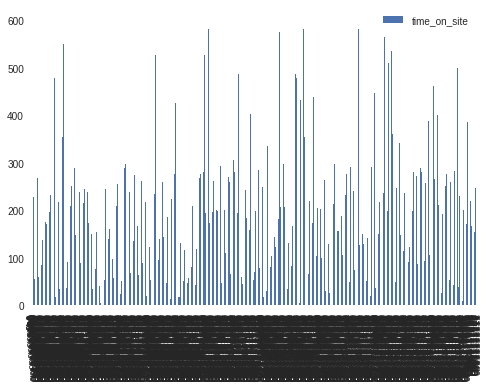

In [11]:
pd.pivot_table(
    user_data, values='time_on_site', index=bin).plot.bar();

In [12]:
pd.crosstab(user_data['mobile'], user_data['purchased'], time_bins, aggfunc=','.join)

purchased,False,True
mobile,,
False,"mobile,purchased,__dummy__","mobile,purchased,__dummy__"
True,"mobile,purchased,__dummy__","mobile,purchased,__dummy__"


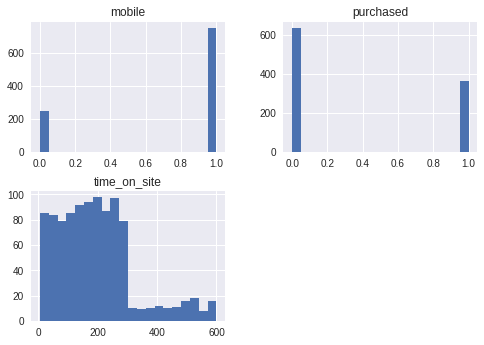

In [13]:
user_data.hist(bins=20);

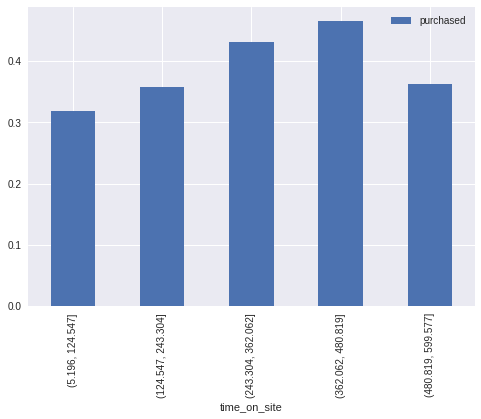

In [14]:
pd.pivot_table(user_data, values='purchased',
               index=time_bins).plot.bar()

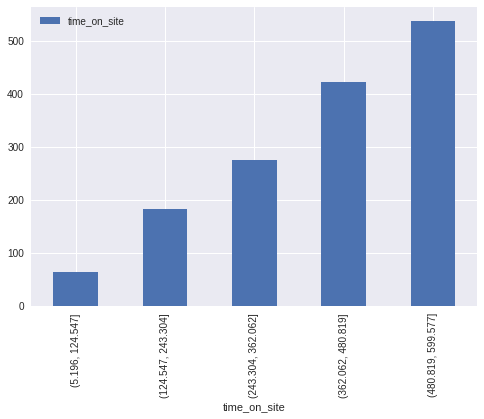

In [15]:
pd.pivot_table(
    user_data, values='time_on_site', index=time_bins).plot.bar();

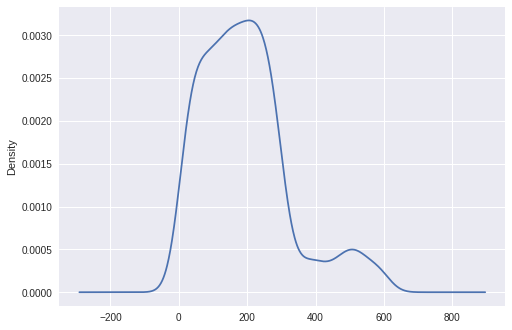

In [16]:
user_data['time_on_site'].plot.density()

In [17]:
ct = pd.crosstab(time_bins, [user_data['purchased'], user_data['mobile']],
                 normalize='columns')
print(type(ct))
ct

<class 'pandas.core.frame.DataFrame'>


purchased              False               True           
mobile                 False     True      False     True 
time_on_site                                              
(5.196, 124.547]    0.210227  0.413043  0.054054  0.351724
(124.547, 243.304]  0.244318  0.423913  0.148649  0.420690
(243.304, 362.062]  0.204545  0.163043  0.243243  0.227586
(362.062, 480.819]  0.130682  0.000000  0.270270  0.000000
(480.819, 599.577]  0.210227  0.000000  0.283784  0.000000

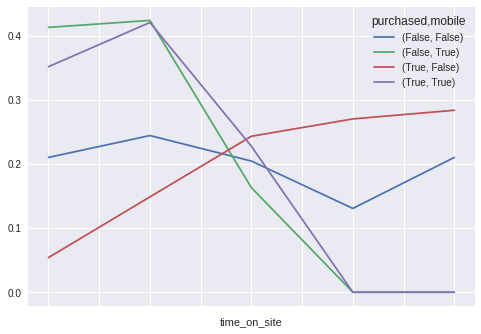

In [18]:
ct.plot();

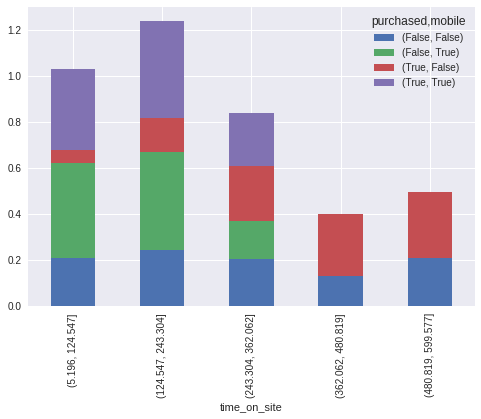

In [19]:
ct.plot(kind='bar', stacked=True);

In [20]:
ct2 = pd.crosstab(user_data['purchased'], [user_data['mobile'], time_bins],
                  normalize='columns')
ct2

mobile                  False                                        \
time_on_site (5.196, 124.547] (124.547, 243.304] (243.304, 362.062]   
purchased                                                             
False                0.902439           0.796296           0.666667   
True                 0.097561           0.203704           0.333333   

mobile                                                        True   \
time_on_site (362.062, 480.819] (480.819, 599.577] (5.196, 124.547]   
purchased                                                             
False                  0.534884           0.637931         0.650685   
True                   0.465116           0.362069         0.349315   

mobile                                                                 \
time_on_site (124.547, 243.304] (243.304, 362.062] (362.062, 480.819]   
purchased                                                               
False                  0.615142           0.531915                0.0   
True                   0.384858           0.468085                0.0   

mobile                           
time_on_site (480.819, 599.577]  
purchased                        
False                       0.0  
True                        0.0

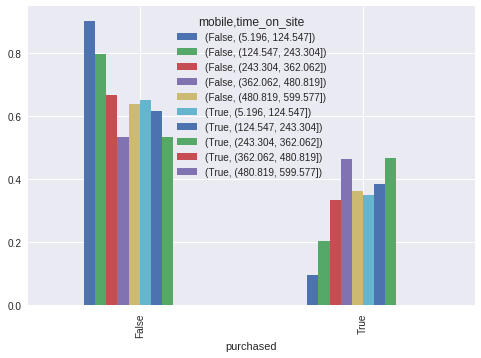

In [21]:
ct2.plot(kind='bar');

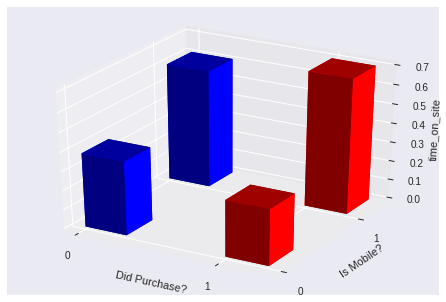

In [22]:
# Trying 3D barplot courtesy of Cole
%matplotlib inline

from mpl_toolkits.mplot3d import Axes3D
import matplotlib.pyplot as plt
import numpy as np
%matplotlib inline

data = pd.crosstab(user_data['purchased'], user_data['mobile'], normalize='columns').values

column_names = ['True','False']
row_names = ['True','False']
fig = plt.figure()
ax = Axes3D(fig)

lx= 2
ly= 2
xpos = np.array([1,0])
ypos = np.array([1,0])
xpos, ypos = np.meshgrid(xpos, ypos)

xpos = xpos.flatten()
ypos = ypos.flatten()
zpos = np.zeros(lx*ly)

dx = 0.3 * np.ones_like(zpos)
dy = dx.copy()
dz = data.flatten()

cs = ['r', 'b'] * ly

ax.bar3d(xpos, ypos, zpos, dx, dy, dz, color=cs)

ax.axes.set_xticks([1,0])
ax.axes.set_yticks([1,0])
ax.set_xlabel('Did Purchase?')
ax.set_ylabel('Is Mobile?')
ax.set_zlabel('time_on_site')

plt.show()

## Assignment - what's going on here?

Consider the data in `persons.csv` (already prepared for you, in the repo for the week). It has four columns - a unique id, followed by age (in years), weight (in lbs), and exercise time (in minutes/week) of 1200 (hypothetical) people.

Try to figure out which variables are possibly related to each other, and which may be confounding relationships.

In [23]:
# TODO - your code here
# Use what we did live in lecture as an example
persons_df = pd.read_csv('https://raw.githubusercontent.com/standroidbeta/DS-Unit-1-Sprint-1-Dealing-With-Data/master/module4-databackedassertions/persons.csv')

print(persons_df.shape)
persons_df.head()
# HINT - you can find the raw URL on GitHub and potentially use that
# to load the data with read_csv, or you can upload it yourself

(1200, 4)


,Unnamed: 0,age,weight,exercise_time
0,0,44,118,192
1,1,41,161,35
2,2,46,128,220
3,3,39,216,57
4,4,28,116,182


In [24]:
persons_df.isnull().sum()

Unnamed: 0       0
age              0
weight           0
exercise_time    0
dtype: int64

In [25]:
persons_df.isna().sum()

Unnamed: 0       0
age              0
weight           0
exercise_time    0
dtype: int64

In [26]:
persons_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1200 entries, 0 to 1199
Data columns (total 4 columns):
Unnamed: 0       1200 non-null int64
age              1200 non-null int64
weight           1200 non-null int64
exercise_time    1200 non-null int64
dtypes: int64(4)
memory usage: 37.6 KB


In [27]:
persons_df = persons_df.rename({'Unnamed: 0':'person_index_id'}, axis="columns")

persons_df.head()

,person_index_id,age,weight,exercise_time
0,0,44,118,192
1,1,41,161,35
2,2,46,128,220
3,3,39,216,57
4,4,28,116,182


In [35]:
age_bins = pd.cut(persons_df['age'], 7)
weight_bins = pd.cut(persons_df['weight'], 42)

pd.crosstab(persons_df['age'], [persons_df['weight'], age_bins], 
            rownames=['person_index_id'], 
            colnames=["exersize_times", "weight"])




exersize_times               100                                    \
weight          (17.938, 26.857] (26.857, 35.714] (35.714, 44.571]   
person_index_id                                                      
18                             0                0                0   
19                             0                0                0   
20                             0                0                0   
21                             0                0                0   
22                             0                0                0   
23                             0                0                0   
24                             0                0                0   
25                             0                0                0   
26                             0                0                0   
27                             0                0                0   
28                             0                0                0   
29                             0                1                0   
30                             0                0                0   
31                             0                0                0   
32                             0                0                0   
33                             0                1                0   
34                             0                0                0   
35                             0                0                0   
36                             0                0                0   
37                             0                0                2   
38                             0                0                0   
39                             0                0                0   
40                             0                0                1   
41                             0                0                0   
42                             0                0                0   
43                             0                0                0   
44                             0                0                0   
45                             0                0                0   
46                             0                0                0   
47                             0                0                0   
...                          ...              ...              ...   
51                             0                0                0   
52                             0                0                0   
53                             0                0                0   
54                             0                0                0   
55                             0                0                0   
56                             0                0                0   
57                             0                0                0   
58                             0                0                0   
59                             0                0                0   
60                             0                0                0   
61                             0                0                0   
62                             0                0                0   
63                             0                0                0   
64                             0                0                0   
65                             0                0                0   
66                             0                0                0   
67                             0                0                0   
68                             0                0                0   
69                             0                0                0   
70                             0                0                0   
71                             0                0                0   
72                             0                0                0   
73                             0                0                0   
74        

### Assignment questions

After you've worked on some code, answer the following questions in this text block:

1.  What are the variable types in the data?
2.  What are the relationships between the variables?
3.  Which relationships are "real", and which spurious?


## Stretch goals and resources

Following are *optional* things for you to take a look at. Focus on the above assignment first, and make sure to commit and push your changes to GitHub.

- [Spurious Correlations](http://tylervigen.com/spurious-correlations)
- [NIH on controlling for confounding variables](https://www.ncbi.nlm.nih.gov/pmc/articles/PMC4017459/)

Stretch goals:

- Produce your own plot inspired by the Spurious Correlation visualizations (and consider writing a blog post about it - both the content and how you made it)
- Pick one of the techniques that NIH highlights for confounding variables - we'll be going into many of them later, but see if you can find which Python modules may help (hint - check scikit-learn)